# Trace metadata visualizer

In [2]:
import numpy as np
import sqlite3 as lite
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os

from utils.db_utils import get_db_absolute_path

In [3]:
# Setup sqlite connection
database = get_db_absolute_path("trace_metadata.db")
con = lite.connect(database)

In [4]:
query = "select * from trace_metadata_depth;"
trace_metadata_depth = pd.read_sql_query(query, con)
trace_metadata_depth

,id,test_dataset_id,training_dataset_id,environment_id,distance,device,additive_noise_method_id,trace_process_id,data_point_index,max_val,min_val,mean_val,rms_val,std_val,snr_val
0,1,1,None,1,15.0,6,None,2,0,0.008866,0.001883,0.004728,0.004771,0.000637,55.020428
1,2,1,None,1,15.0,6,None,2,1,0.009523,0.002287,0.006070,0.006092,0.000518,137.369634
2,3,1,None,1,15.0,6,None,2,2,0.008784,0.003245,0.005202,0.005238,0.000610,72.626607
3,4,1,None,1,15.0,6,None,2,3,0.011342,0.003219,0.006682,0.006784,0.001176,32.295103
4,5,1,None,1,15.0,6,None,2,4,0.010359,0.003787,0.007520,0.007586,0.000995,57.130985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10395,10396,2,None,1,10.0,10,None,3,395,1.000000,0.037372,0.478522,0.487874,0.095064,25.337886
10396,10397,2,None,1,10.0,10,None,3,396,0.990829,0.000000,0.469927,0.479970,0.097673,23.148144
10397,10398,2,None,1,10.0,10,None,3,397,0.927822,0.000000,0.472598,0.481864,0.094047,25.251863
10398,10399,2,None,1,10.0,10,None,3,398,0.836972,0.052175,0.470410,0.479380,0.092301,25.973862


In [5]:
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='orange', lw=4)]

In [6]:
def plot_trace_metadata(test_dataset_id, distance, device, trace_process_id):
    query = f"""
    select
        *
    from 
        trace_metadata_depth
    where
        test_dataset_id = {test_dataset_id}
        AND distance = {distance}
        AND trace_process_id = {trace_process_id}
        AND device = {device}
    ;
    """
    data = pd.read_sql_query(query, con)
    data[204:314].plot(x="data_point_index", y="mean_val", figsize=(10, 8))
    mean_mean = np.mean(data[204:314]["mean_val"], axis=0)
    mean_rms = np.mean(data[204:314]["rms_val"], axis=0)
    mean_std = np.mean(data[204:314]["std_val"], axis=0)
    mean_snr = np.mean(data[204:314]["snr_val"], axis=0)
    np.mean(data[204:314]["min_val"], axis=0)
    plt.title(
        f"""
        Dataset {test_dataset_id}, Distance {distance}m, Device {device}, Processing_id: {trace_process_id}\n
        Mean: {round(mean_mean, 4)}, RMS: {round(mean_rms, 4)}, Std: {round(mean_std, 5)}, SNR: {round(mean_snr,2)}
        """
    )
    plt.axhline(mean_mean, c="r")
    plt.axhline(mean_rms, c="g")
    labels = ["Mean", "Mean Mean", "Mean RMS"]
    plt.legend(custom_lines, labels)
    plt.show()
    return

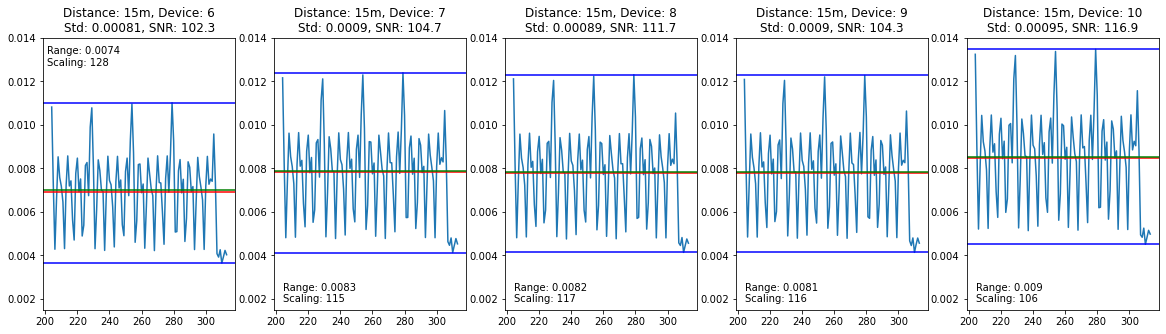

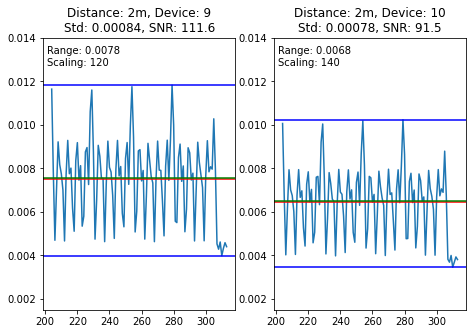

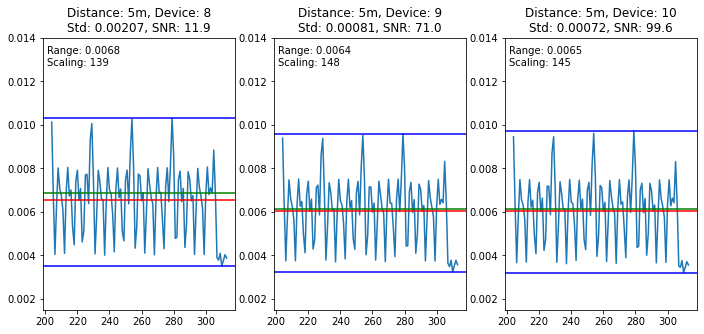

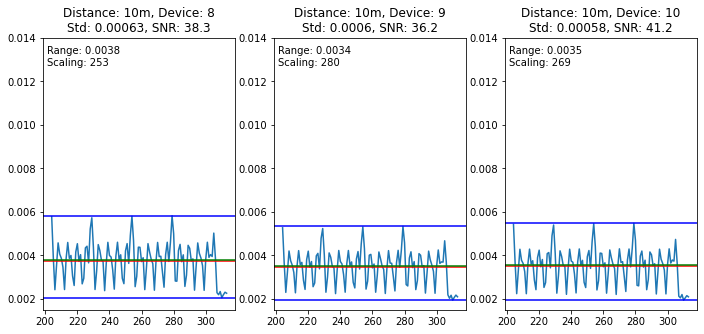

In [7]:
query = "select * from trace_metadata_depth;"
raw_data = pd.read_sql_query(query, con)

set1 = (1, [6, 7, 8, 9, 10], [15])
set2 = (2, [9, 10], [2])
set3 = (2, [8, 9, 10], [5])
set4 = (2, [8, 9, 10], [10])
sets = [set1, set2, set3, set4]

for subset in sets:
    plt.figure(figsize=(20,len(subset[2])*5))
    plt.subplots_adjust(hspace=0.5)
    #plt.suptitle("Daily closing prices", fontsize=18, y=0.95)
    i=1
    for distance in subset[2]:
        for device in subset[1]:
            ax = plt.subplot(len(subset[2]), 5, i)
            ax.set_ylim(0.0015, 0.014)
            data = raw_data.copy()
            data = data[data["distance"] == distance]
            data = data[data["device"] == device]
            data = data[data["trace_process_id"] == 2]
            data = data[data["test_dataset_id"] == subset[0]]
            data[204:314].plot(x="data_point_index", y="mean_val", ax=ax)
            
            top_value = np.max(data[204:314]["mean_val"], axis=0)
            bottom_value = np.min(data[204:314]["mean_val"], axis=0)
            dyn_range = top_value - bottom_value
            scaling_factor = 1/(max(data["mean_val"]) - min(data["mean_val"]))
            mean_mean = np.mean(data[204:314]["mean_val"], axis=0)
            mean_rms = np.mean(data[204:314]["rms_val"], axis=0)
            mean_std = round(np.mean(data[204:314]["std_val"], axis=0), 5)
            mean_snr = round(np.mean(data[204:314]["snr_val"], axis=0), 1)
            ax.axhline(top_value, c="b")
            ax.axhline(bottom_value, c="b")
            ax.axhline(mean_mean, c="r")
            ax.axhline(mean_rms, c="g")
            if round(top_value,5) < 0.012:
                ax.text(
                    0.02, 0.97, 
                    f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes
                )
            else:
                ax.text(
                    0.05, 0.1, 
                    f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes
                )
            i+=1
            ax.set_title(
                f"""Distance: {distance}m, Device: {device}\nStd: {mean_std}, SNR: {mean_snr}"""
            )
            ax.get_legend().remove()
            ax.set_xlabel("")
    plt.show()

### Bigger plots

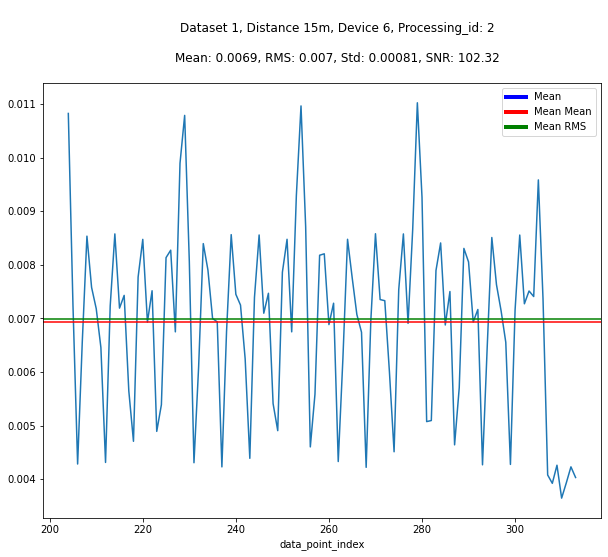

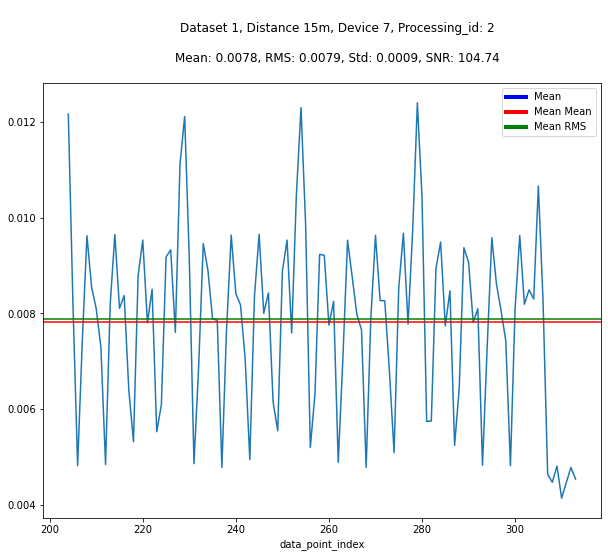

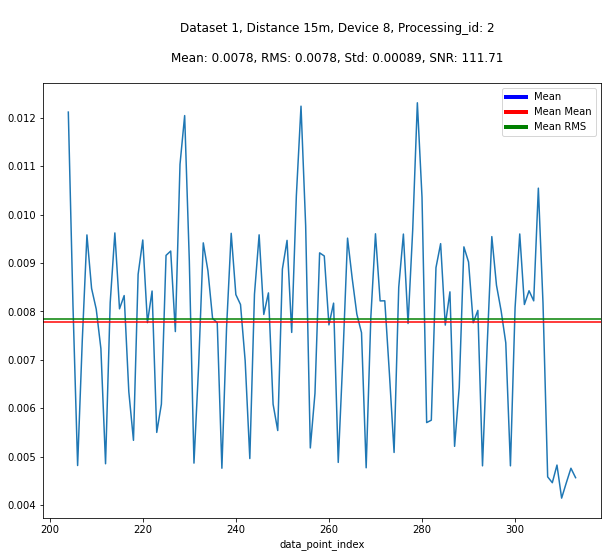

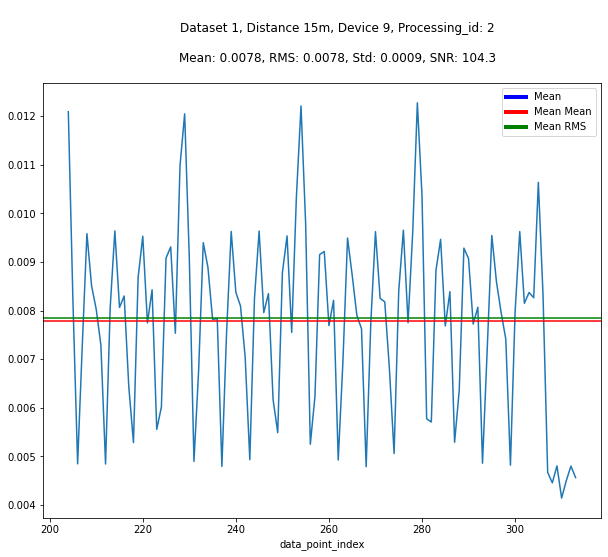

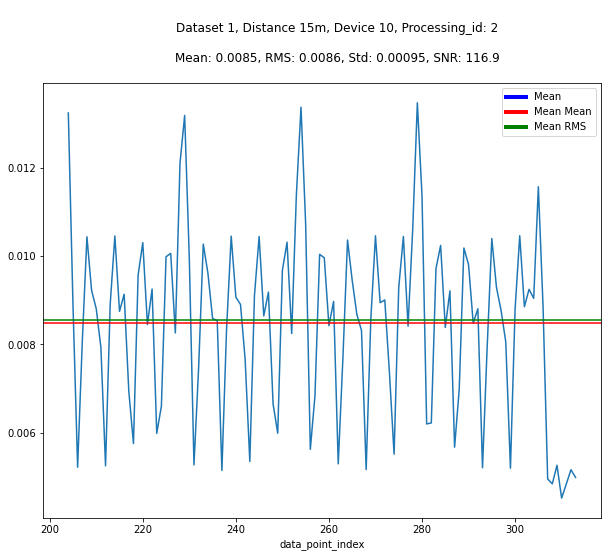

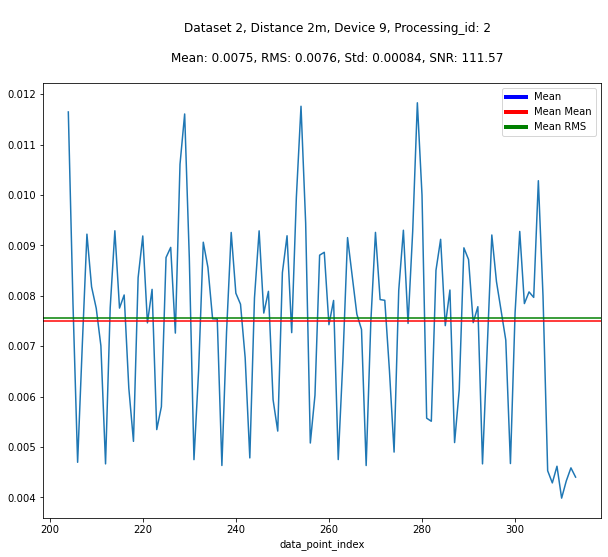

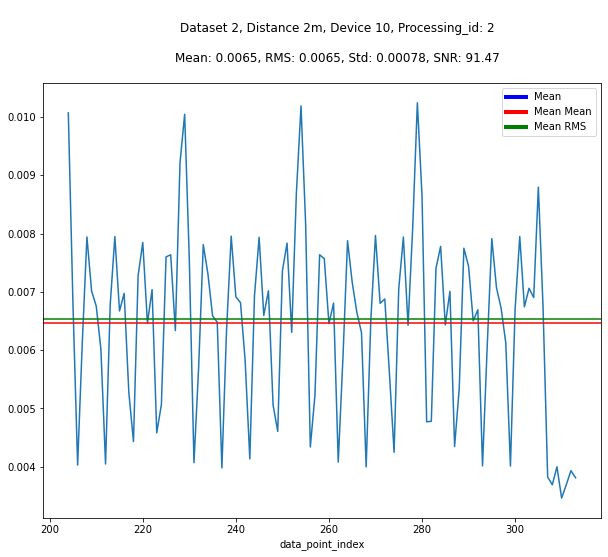

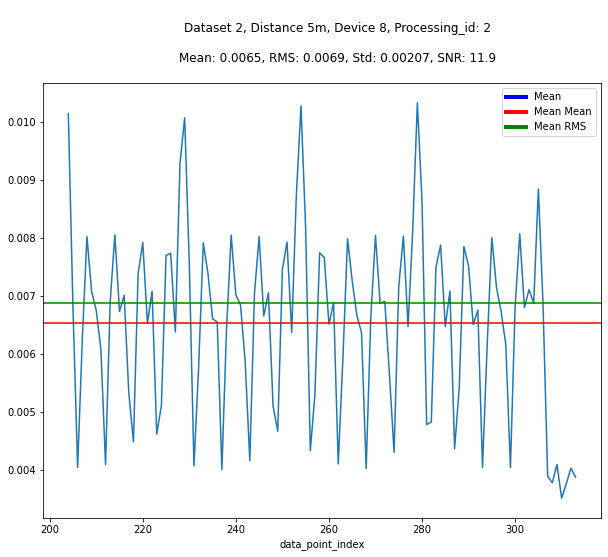

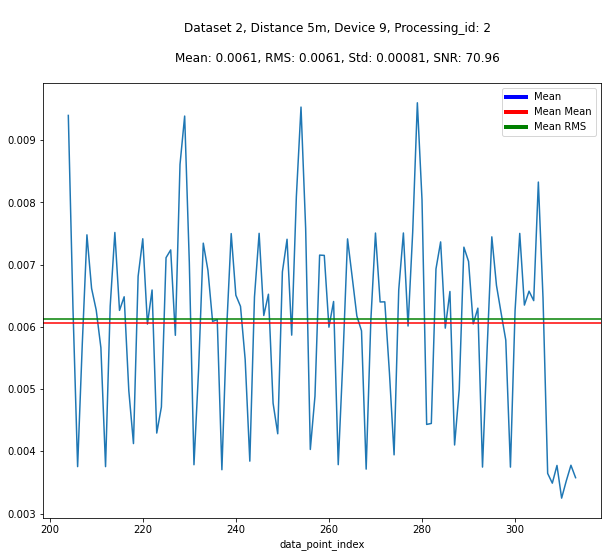

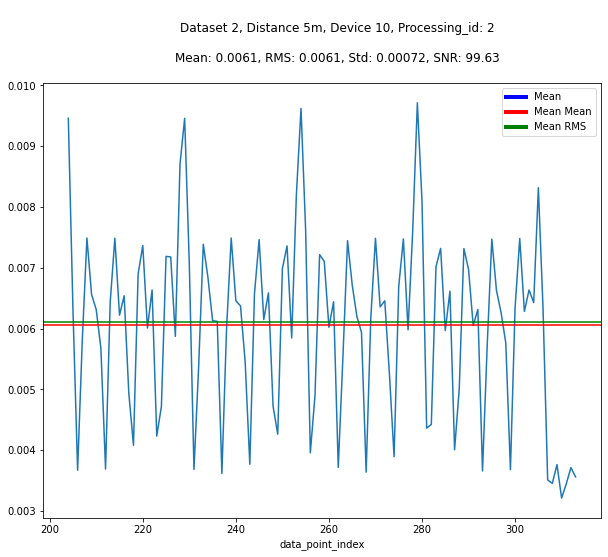

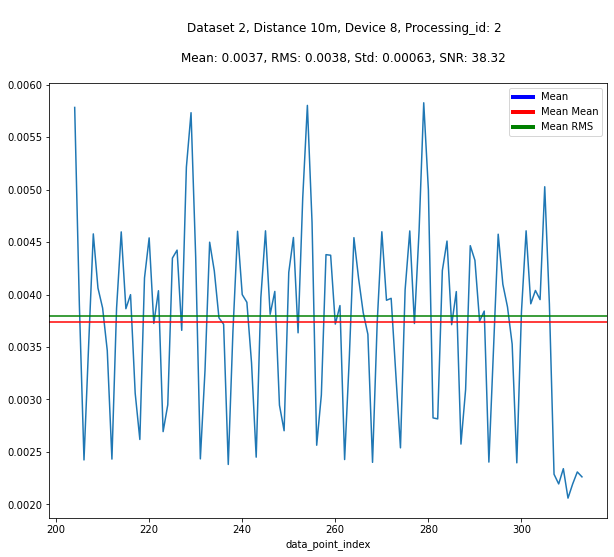

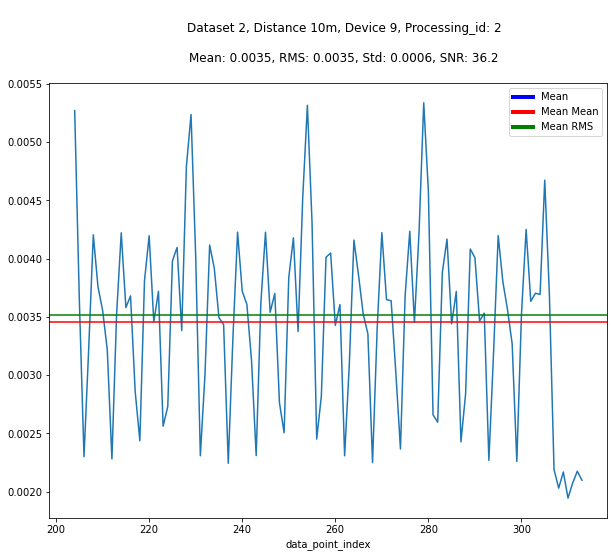

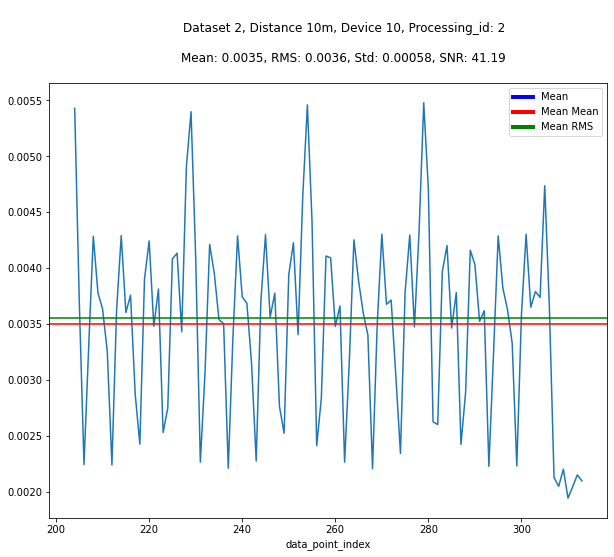

In [9]:
set1 = (1, [6, 7, 8, 9, 10], 15)
set2 = (2, [9, 10], 2)
set3 = (2, [8, 9, 10], 5)
set4 = (2, [8, 9, 10], 10)
sets = [set1, set2, set3, set4]
for subset in sets:
    for device in subset[1]:
        test_dataset_id = subset[0]
        distance = subset[2]
        plot_trace_metadata(test_dataset_id, distance, device, 2)